Today's goal (0220)

--- get the PWV for each model

--- get the model data plot
0220 not finished PWv
0221 check unit

Larosa, S., Cimini, D., Gallucci, D., Nilo, S. T., and Romano, F.: PyRTlib: an educational Python-based library for non-scattering atmospheric microwave radiative transfer computations, Geosci. Model Dev., 17, 2053–2076, https://doi.org/10.5194/gmd-17-2053-2024, 2024.

Kelsey, V., Riley, S., and Minschwaner, K.: Atmospheric precipitable water vapor and its correlation with clear-sky infrared temperature observations, Atmos. Meas. Tech., 15, 1563–1576, https://doi.org/10.5194/amt-15-1563-2022, 2022.

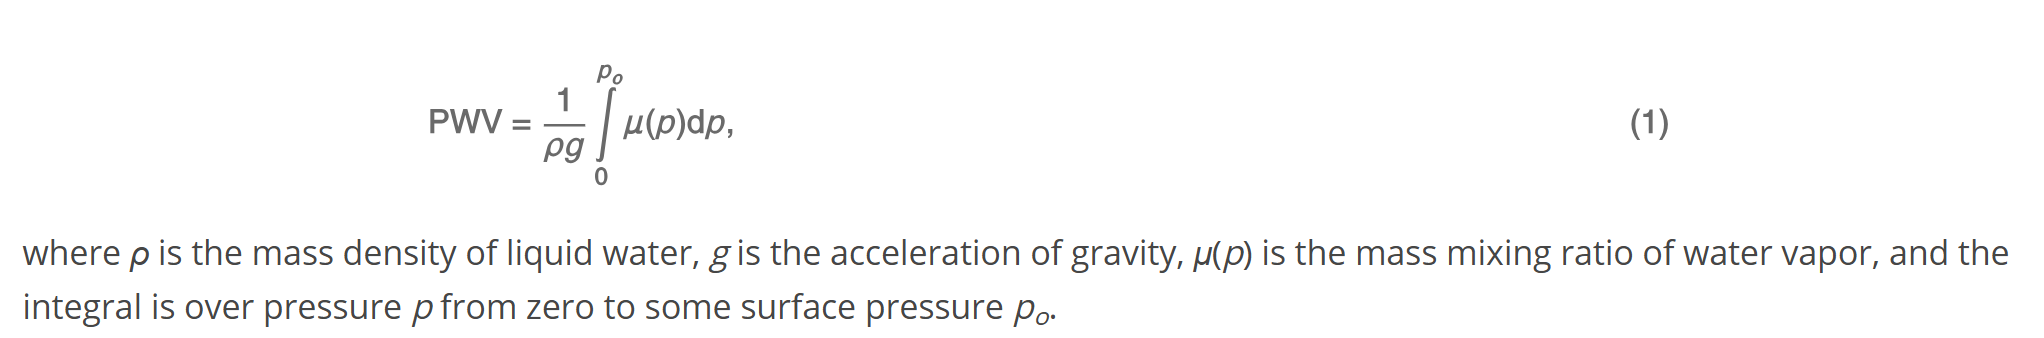

https://amt.copernicus.org/articles/15/1563/2022/

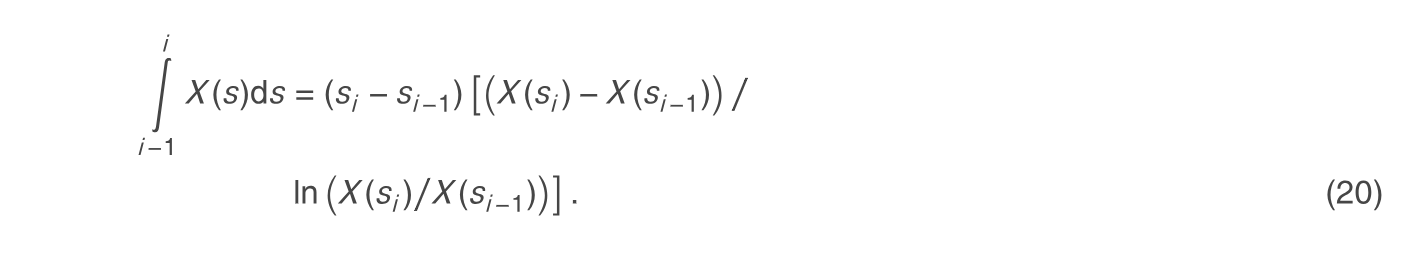

https://gmd.copernicus.org/articles/17/2053/2024/#section3

#How get PWV


use pyRTlib to get model mass mixing ratio and relative pressure

mass mixing ratio is from ppmv (pyrtlib.utils.ppmv2gkg --> unit g/kg)

pressure #from pyrtlib.climatology import AtmosphericProfiles.gl_atm(model(int)) --> unit mbar

Goal PWV unit is mm(milli meter)

unit check:

    mass mixing ratio: g/kg need to convert to kg/kg

    pressure: mbar

    mass density of water vapor: kg/m^3 

    g is the acceleration due to gravity (9.8 m/s^2)

    ( (kg/kg) * mbar ) / ( (kg/m^3) * (m/s^2) ) = meter need to convert to mm

#mass density of water vapor 

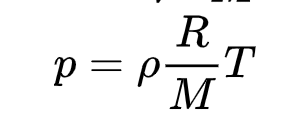
https://en.wikipedia.org/wiki/Ideal_gas_law

p is Partial Pressure of Water Vapor (p_w)

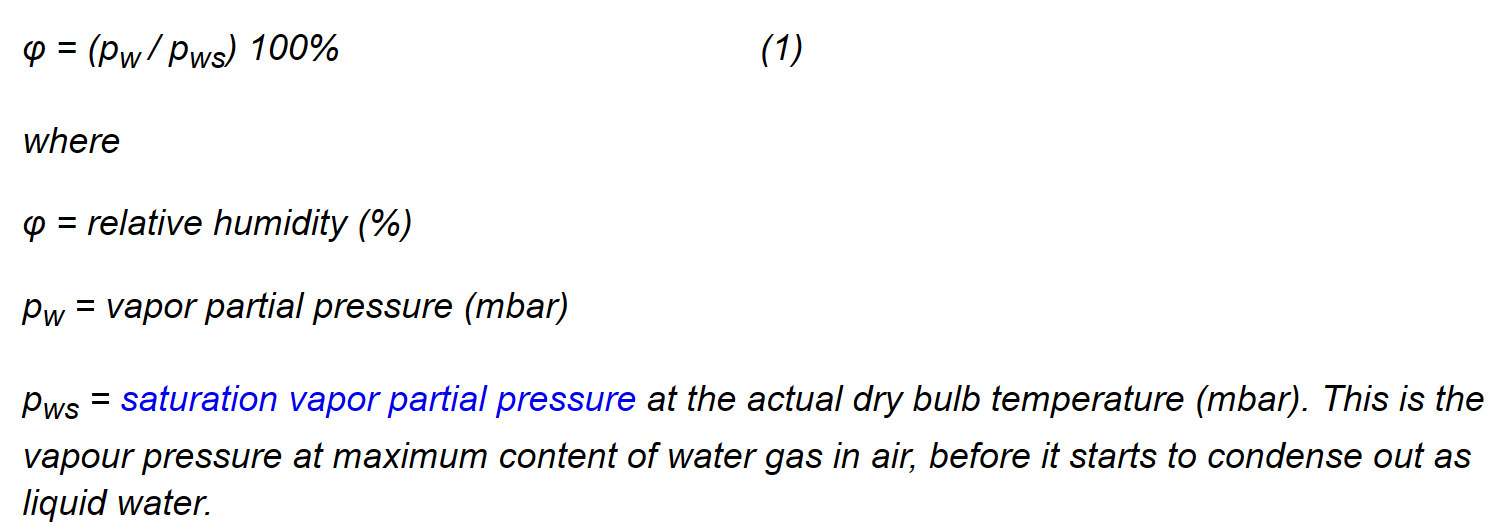
https://www.engineeringtoolbox.com/relative-humidity-air-d_687.html

p_w = RH * P_sat

$ pho = (RH * P_sat * M) / (R * T) $

M is the molar mass of water (≈18.015 g/mol --> 0.018015 kg/mol)
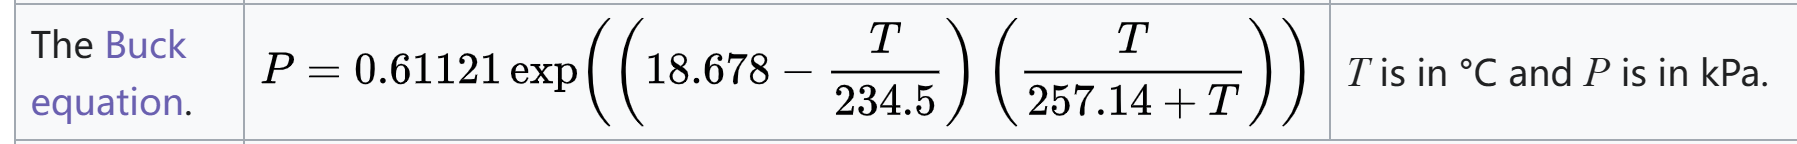
P_sat is the saturation vapor pressure (!our data temp is out of the range -50C (220K) to 80C (350K))

T is the temperature in kelvins


R is the ideal, or universal, gas constant, equal to the product of the Boltzmann constant and the Avogadro constant R is the ideal gas constant (≈8.314 J/(mol·K))

unit check: pa(=J/m^3) * (kg/mol) /( (J/(mol*K)) * K ) = kg/m^3

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from pyrtlib.climatology import AtmosphericProfiles as atmp

#from pyrtlib.tb_spectrum import TbCloudRTE

from pyrtlib.utils import ppmv2gkg, mr2rh


def saturation_vapor_pressure(temp):
    """
    Calculate the saturation vapor pressure of water at a given temperature.
    input:
        temp in K
    output:
        P_sat in Pa
    """
    #change temp to Celsius
    temp = temp - 273.15
    P_sat = 0.61121 * np.exp( (18.678 - temp / 234.5) * ( temp / (257.14 + temp) ) ) # in kPa
    P_sat = P_sat * 1000 # convert to Pa

    return P_sat

def mass_density(rh,temp):
    """
    Calculate the mass density of water vapor at a given temperature and RH.
    input:
        rh unitless(decimal)
        Temp in K
    
    output:
        rho_w in kg/m^3
    """
    #get P_sat
    P_sat = saturation_vapor_pressure(temp)
    M_water = 18.01528e-3 # kg/mol
    R = 8.314 # J/(mol K)
    P_w = rh * P_sat #Partial Pressure of Water Vapor (Pa)
    #!It seems we have a function for partical pressure!
    #print(P_w*0.001,"kPa")
    rho_w = P_w * M_water / (R * temp) #kg/m^3

    return rho_w

"""#test for partial pressure of water vapor
# Temp = 273.15 +21 #K
# print(saturation_vapor_pressure(Temp)*0.01,"mbar")
# rh = 0.41 
# print(mass_density(rh,Temp))
# Example: Relative Humidity and Vapor Pressure

From the table above the saturation pressure at 70 oF (21 oC) is 25.0 mbar. 
If the vapor pressure in the actual air is 10.3 mbar the relative humidity can be calculated as:
φ = ((10.2 mbar) / (25.0 mbar)) 100 (%) = 41 (%)
example from https://www.engineeringtoolbox.com/relative-humidity-air-d_687.html
"""

"""#test for mass density
temp = 273.15 + 121 #K
#need adjust RH let partial pressure of water vapor = 101 kPa
rh = 0.493
print(mass_density(rh,temp)) #kg/m^3
reasonable error compared to the value from the table of web:
https://www.engineeringtoolbox.com/densities-specific-volumes-dry-air-water-vapor-d_1575.html
"""

#get TROPICAL ATMOSPHERIC PROFILE
atm_Tro = atmp.TROPICAL
z, p, _, t, md = atmp.gl_atm(atm_Tro)
md_H2O = md[:,atmp.H2O]

# z: Altitudes (km) 
# p: Pressure (mbar)
# t: Temperature (K)
# md: Molecular densities (ppmv)

p_pa = p*1e2 # convert mbar to Pa

m_mix_gkg = ppmv2gkg(md_H2O,atmp.H2O) # convert to g/kg
m_mix_kgkg = m_mix_gkg * 1e-3 # convert to kg/kg (g/g?)

rh_per = mr2rh(p,t,m_mix_gkg)[0] # %
rh_dec = rh_per * 0.01 # unitless
"""test for mr2rh 
p_test = np.array([1,2])
t_test = np.array([283.15,283.15])
m_mix_gkg_test = np.array([20,20])
print("test rh:",mr2rh(p_test,t_test,m_mix_gkg_test))
"""

"""#---!!! Unfortunately, we can't use this bc m_mix_kgkg[19] == m_mix_kgkg[20]
# so ln ( X[i] / X[i-1]) will be 0 ---!!!
def sumInte(X,s):
    
    # This is used to compute path-integrated quantities ... eq. (20) from (Larosa et al., 2024)
    # Inte from i-1 to i X(s)ds = 
    #     (s[i]-s[i-1]) * ( (X[i] - X[i-1]) / (ln ( X[i] / X[i-1]) ) )

    #for i in range(len(s)) i will be 0 to len(s)-1

    so the integration will be 
        from s[0] to s[1] +...+ from s[48] to s[49] 
        total sum of 49 times?
    
    sumInte = 0

    for i in range(len(s)-1):
        
        sumInte += (s[i+1]-s[i]) * ( ( X[i+1] - X[i] )/( np.log( X[i+1] / X[i]) ) )
        # if not np.isfinite(sumInte):
        #     print(i,sumInte)
        #     break

    return sumInte

#test for sumInte
#print(sumInte(m_mix_kgkg,z)) !!! not work"""

def sumInte4const(X,s,A):
    """ this function is used to compute path-integrated quantities for constant X
    """
    
    sumInte = 0

    for i in range(len(s)-1):

        # fix the negative out set delta s is positive

        del_s = np.abs( s[i+1]-s[i] ) 
        del_X = np.abs( X[i+1] - X[i] )
        del_A = np.abs( A[i+1] - A[i] )

        sumInte += del_X * del_s / del_A

    return sumInte

#test for sumInte4const
#print(sumInte4const(m_mix_kgkg,p_pa,1))#  got some value

def PWV_from_mmix(rho,g,m_mix_kgkg,p_pa):
    """
    Calculate the precipitable water vapor from the mixing ratio.


    input:
        rho_w in kg/m^3
        g in m/s^2
        mass mixing ratio of water vapor in kg/kg
        pressure in Pa
        
    output:
        PWV in mm
    """
    sum_m_P_rho = sumInte4const(m_mix_kgkg,p_pa,rho) 
    
    
    PWV_meter = sum_m_P_rho / g # in m

    PWV = PWV_meter * 1000 # convert to mm

    return PWV



rho_w = mass_density(rh_dec,t)
#print(rho_w)
from pyrtlib.utils import mr2rho
rho_w_func = mr2rho(p,t,m_mix_gkg) #g/m^3

rho_w_func = rho_w_func * 1e-3 # convert to kg/m^3

g = 9.8 # m/s^2

PWV = PWV_from_mmix(rho_w_func,g,m_mix_kgkg,p_pa)

print(PWV,"mm")


47222168.29638183 mm


In [30]:

atms = [atmp.TROPICAL, atmp.MIDLATITUDE_SUMMER, atmp.MIDLATITUDE_WINTER, atmp.SUBARCTIC_SUMMER, atmp.SUBARCTIC_WINTER, atmp.US_STANDARD]

for atm in atms:
   z, p, _, t, md = atmp.gl_atm(atm)
   md_H2O = md[:,atmp.H2O]
   p_pa = p*1e2 # convert to Pa
   m_mix_gkg = ppmv2gkg(md_H2O,atmp.H2O) # convert to g/kg
   m_mix_kgkg = m_mix_gkg * 1e-3 # convert to kg/kg (g/g?)
   rh_per = mr2rh(p,t,m_mix_gkg)[0] # %
   rh_dec = rh_per * 0.01 # unitless
   rho_w_func = mr2rho(p,t,m_mix_gkg)
   PWV = PWV_from_mmix(rho_w_func,g,m_mix_kgkg,p_pa)
   print(PWV,"mm")

103217.01633204744 mm
103280.32650870479 mm
103708.92602732872 mm
103160.5706031305 mm
103503.52598067514 mm
103079.11686269633 mm


PWV about 800~1000 mm
which I don't think that is correct
AI search for the PWV and get the value less 100 mm and 70 mm consider as Very humid
!need check unit